<a href="https://colab.research.google.com/github/Seoyangsam/Predict_wine_quality/blob/main/vine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import of Packages

In [ ]:
# Package imports
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pickle # saving models

import random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize

Upload the file:

In [ ]:
# Build in colab for local data upload
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User has uploaded file "{name}" with length "{length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

Saving winequality-red.csv to winequality-red (1).csv
Saving winequality-white.csv to winequality-white (1).csv
User has uploaded file "winequality-red (1).csv" with length "84199 bytes
User has uploaded file "winequality-white (1).csv" with length "264426 bytes


Reading the file:

In [ ]:
# Creating merged white and red wines.
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

col_red = np.repeat('red', len(red))
col_white = np.repeat('white', len(white))
red['wine_type'] = col_red
white['wine_type'] = col_white

df = red.append(white, ignore_index=True)

##### Binning Quality ####### explanations needed for the ranges
bins = (0, 5, 7, 10) ### Bad = [0-5], Medium = [6-7] and good = [8-10]
labels = ('bad', 'medium', 'good')
df['qualitycat'] = pd.cut(df['quality'], bins = bins, labels = labels)

<ipython-input-19-755cc1e873e6>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = red.append(white, ignore_index=True)


### helper functions

In [ ]:
def feature_dist(dataframe):
    col_num = len(dataframe.columns)
    from_to_ind = [(i, i+6) for i in range(0, col_num, 6)]

    for i, j in from_to_ind:
        if j >= col_num:
            if col_num - 1 == i:
                dataframe.iloc[:, i].hist(figsize=(11,4))
            else:
                dataframe.iloc[:, i:col_num-1].hist(layout=(1,col_num - 1 - i), figsize=(11,4))
        else:
            dataframe.iloc[:, i:j].hist(layout=(2,3), figsize=(11,4))

### Helper Function for evaluating models

def conf_mat(grid_search: GridSearchCV, Y_pred, Y_test):
    outcome_class_labels = ["bad", "medium", "good"]
    cm = confusion_matrix(
        y_test,
        Y_pred,
        labels = outcome_class_labels
    )
    # create heatmap
    sns.heatmap(
        cm,
        annot=True,
        cmap='Blues',
        xticklabels=outcome_class_labels,
        yticklabels=outcome_class_labels,
        fmt='d')
    # add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    # print classification_report:
    print(classification_report(
        Y_test,
        Y_pred,
        target_names = outcome_class_labels,
        labels= outcome_class_labels,
        digits=4))

    return cm


def print_feature_imp(colnames, grid_search: GridSearchCV):
  # Get the feature importances
  feature_importances = grid_search.best_estimator_.named_steps['model'].feature_importances_
  # Create a dictionary mapping feature names to importances
  feature_importances_dict = dict(zip(colnames, feature_importances))
  # Sort the dictionary by importance in descending order
  sorted_feature_importances = dict(sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True))
  # Extract the feature names and importances for plotting
  features = list(sorted_feature_importances.keys())
  importances = list(sorted_feature_importances.values())
  # Plot the feature importances
  plt.figure(figsize=(12, 6))
  plt.barh(range(len(features)), importances, align='center')
  plt.yticks(range(len(features)), features)
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importances')
  plt.show()


def multiclass_roc(grid_search: GridSearchCV, X_test):
  classes = ['bad', 'medium', 'good']
  # Obtain predicted probabilities for each class on the test set
  y_pred_prob = grid_search.predict_proba(X_test)
  # Binarize the true labels and predicted probabilities for ROC curve
  y_test_bin = label_binarize(y_test, classes=classes)
  y_pred_prob_bin = y_pred_prob
  # Compute ROC curve and ROC area for each class
  n_classes = len(classes)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob_bin[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot ROC curves
  plt.figure()
  colors = ['blue', 'green', 'red']
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
              label=f'ROC curve for {classes[i]}: (area = {roc_auc[i]})')

  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Outcome Class')
  plt.legend(loc="lower right")
  plt.show()


def plot_models_acc(dict, naive_classifier):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n]['accuracy'] for n in dict]
    fig, ax = plt.subplots()
    bars = ax.bar(y_pos, values, align='center', alpha=0.5)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(labels,rotation='vertical')
    ax.set_ylabel('accuracy')
    ax.set_title('Accuracy of different models')
    # add a horizontal line at naive_classfier
    ax.axhline(y=naive_classifier, color='r', linestyle='-', label='Naive Classifier')
    ax.legend(loc='lower right')

    # Add percentage labels to the bars
    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, value + 0.01, f'{value:.0%}', ha='center', va='bottom')

    # Add percentage label to the line
    ax.text(-0.1, naive_classifier + 0.01, f'{naive_classifier:.0%}', ha='right', va='bottom', color='r')

    plt.ylim((0.0, 1.0))
    plt.show()

Inspecting that the file is correctly loaded - Variables are of the correct datatype

In [ ]:
df.dtypes

Check that the data looks correct

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,qualitycat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red,bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red,bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red,medium
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red,bad


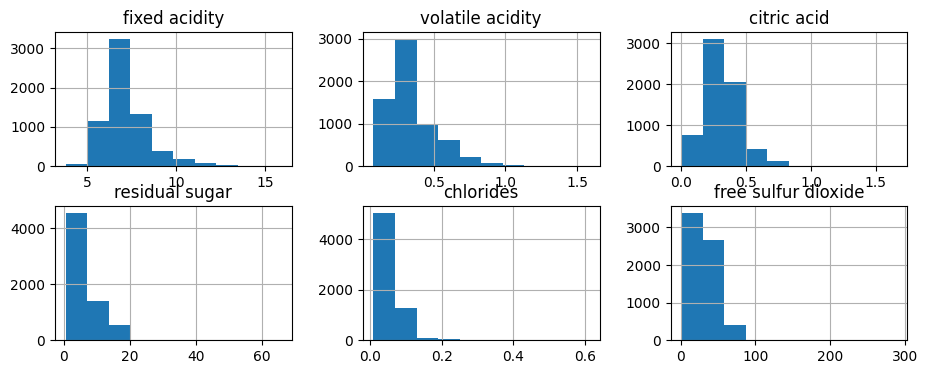

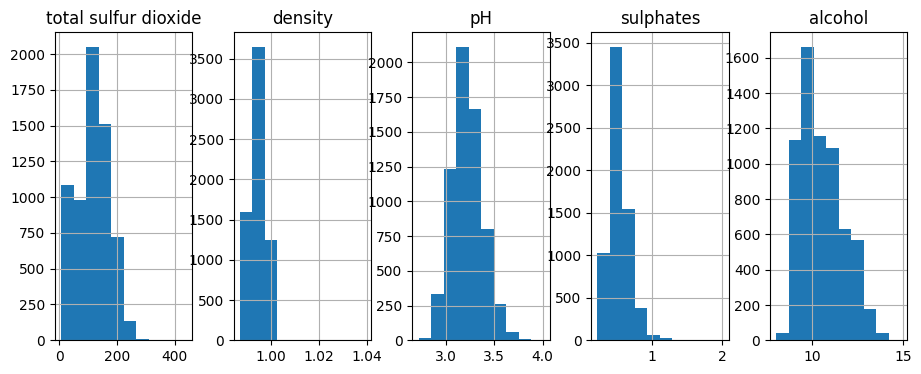

In [ ]:
feature_dist(df.select_dtypes(include=['int64', 'float64']))

Counting the distribution of the dependent Variable:


In [ ]:
df['quality'].value_counts().sort_index()

3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64

In [ ]:
df['qualitycat'].value_counts() ### The class im balance is still big, but better than before with 10 classes

medium    3915
bad       2384
good       198
Name: qualitycat, dtype: int64



Correlation figure of numeric variables:

<ipython-input-59-e7daae31c0f2>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


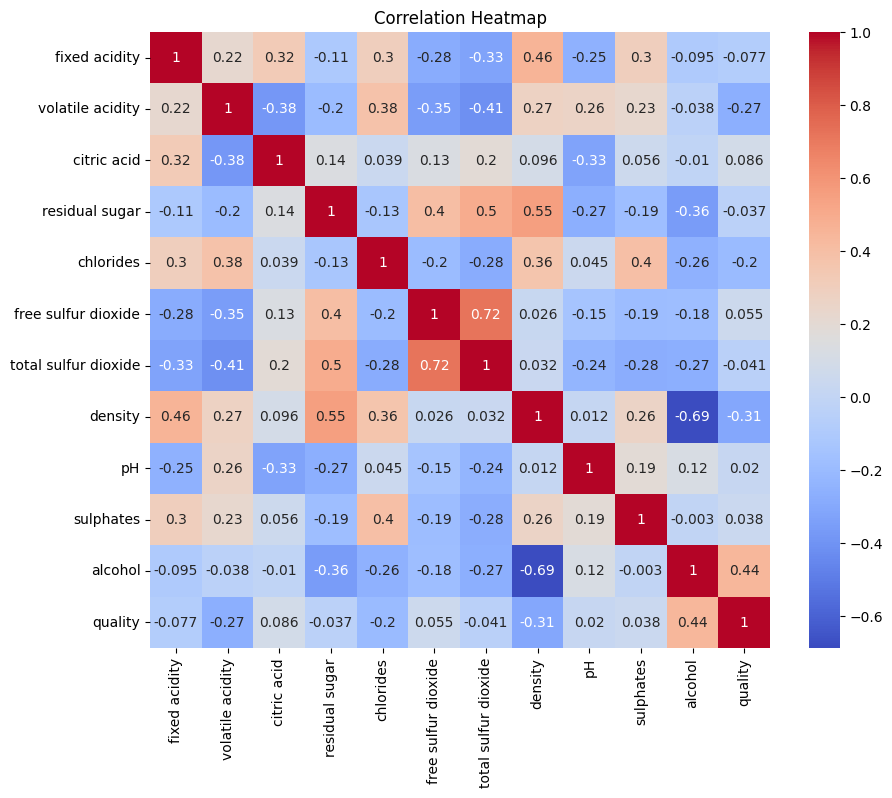

In [ ]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Set the plot title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

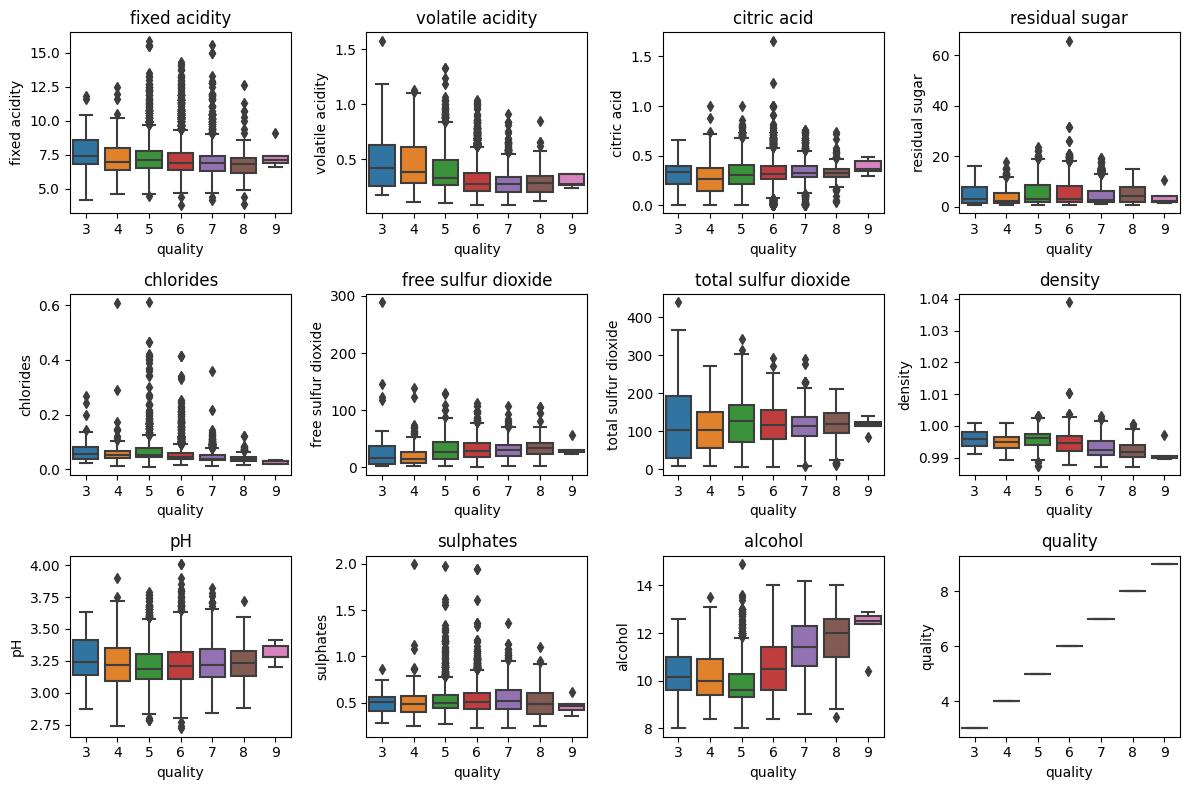

In [ ]:

# Create box plots for each attribute grouped by quality
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
for i, column in enumerate(df.columns[:-2]):
    ax = axes[i // 4, i % 4]
    sns.boxplot(x='quality', y=column, data=df, ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()


Seing the positive correlation between alcohol and quality

<Axes: xlabel='quality', ylabel='alcohol'>

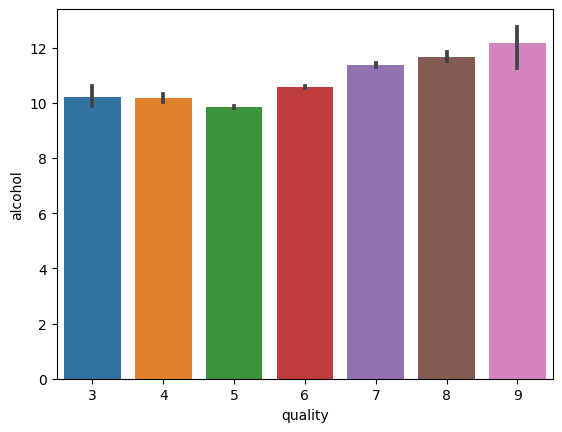

In [ ]:
sns.barplot(x='quality', y='alcohol', data=df)


Seing the positive correlation between alcohol and Citric Acid

In [ ]:
sns.barplot(x='quality', y='citric acid', data=df)

In [ ]:
# Calculate summary statistics for each attribute
summary_stats = df.describe()
print(summary_stats)


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [ ]:

# Check for missing values in the DataFrame
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print(missing_values)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.142473          2.188833    -2.192833       -0.744778   0.569958   
1          0.451036          3.282235    -2.192833       -0.597640   1.197975   
2          0.451036          2.553300    -1.917553       -0.660699   1.026697   
3          3.073817         -0.362438     1.661085       -0.744778   0.541412   
4          0.142473          2.188833    -2.192833       -0.744778   0.569958   
...             ...               ...          ...             ...        ...   
6492      -0.783214         -0.787650    -0.197054       -0.807837  -0.486252   
6493      -0.474652         -0.119460     0.284686        0.537425  -0.257883   
6494      -0.551792         -0.605417    -0.885253       -0.891916  -0.429160   
6495      -1.323198         -0.301694    -0.128234       -0.912936  -0.971538   
6496      -0.937495         -0.787650     0.422326       -0.975995  -1.028631   

      free sulfur dioxide  

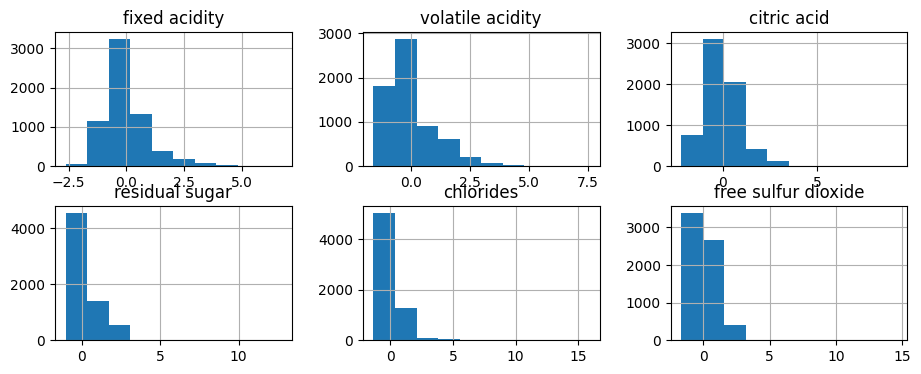

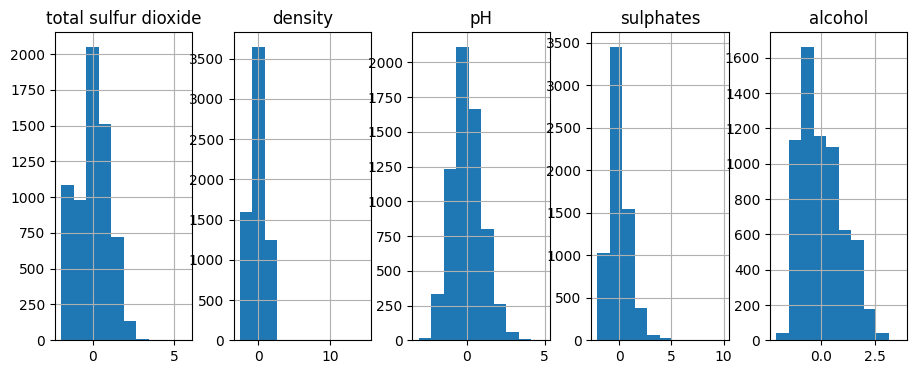

In [ ]:
# To show what the dataset looks like after normalization

from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Apply Standardization to the DataFrame
normalized_df = pd.DataFrame(scaler.fit_transform(df.drop(['wine_type','qualitycat'], axis=1)), columns=df.columns[:-2])

# Print the normalized DataFrame
print(normalized_df)

feature_dist(normalized_df)

# Some data pipeline...

### Initializing the dictionary of tuned models.


In [ ]:
tuned_models = dict()

### Selecting columns of a given type


In [ ]:
objecttypes_num = list(df.select_dtypes(include=['int64', 'float64']).columns)
objecttypes_num = [x for x in objecttypes_num if x != 'quality']

objecttypes_cat = list(df.select_dtypes(include=['object']).columns) # in case of red&white wines
objecttypes_cat

['wine_type']

### Defining steps for data preprocessing before feeding into models

In [ ]:
# Set the random seed
random.seed(2137)
np.random.seed(2137)

y_all = df['qualitycat']
X_all = df.drop(['quality', 'qualitycat'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.25, random_state=2023)

# transformer for numerical columns
transformer_num = Pipeline([
    ('scaler', StandardScaler())
])

# transformer for categorical columns
transformer_cat = Pipeline([
    ('scaler', OneHotEncoder(drop='first'))
])

# jumping into using these in the preprocessor for all features:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', transformer_num, objecttypes_num),
        ('cat', transformer_cat, objecttypes_cat)
], remainder='passthrough')

# the standardization should be based on the training set, hence we obtain the relevant parameters:
x = preprocessor.fit_transform(X_train)

# storing for later
processed_colnames = preprocessor.get_feature_names_out()
processed_colnames = [x.replace('num__', '').replace('cat__','') for x in processed_colnames]
processed_colnames

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'wine_type_white']

### Naive Classifier to compare with - Predicting the most common class

In [ ]:
naive_classifier = sum(y_test == 'medium') / len(y_test)
print(f'The naive classifier on the test set is: {naive_classifier}')

The naive classifier on the test set is: 0.6073846153846154


## RF Classification



In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('model', RandomForestClassifier(random_state=2023))
])

# Define the parameter grid
param_grid = {
    'model__n_estimators': [50, 100, 200, 500, 1000],
    'model__criterion': ['gini'],
    'model__max_depth': [None],
    'model__min_samples_split': [2, 4, 6, 8, 10],
    'model__min_samples_leaf': [1, 2, 5, 10],
    'model__max_features': ['sqrt']
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=4, verbose=2, n_jobs=4)

# fit the grid search object to the data
grid_search.fit(X_train, y_train)

# evaluate the best model on the test set
score = grid_search.score(X_test, y_test)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

#print('Accuracy on the test set: ', score)
print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Accuracy on the test set:  0.8313846153846154

Best parameters after the grid search:  {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 4, 'model__n_estimators': 100}

Time taken for model to learn:  923.411294221878  seconds


## RF Results

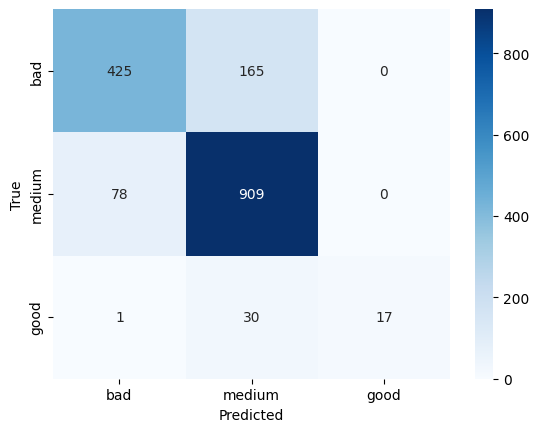

              precision    recall  f1-score   support

         bad     0.8433    0.7203    0.7770       590
      medium     0.8234    0.9210    0.8694       987
        good     1.0000    0.3542    0.5231        48

    accuracy                         0.8314      1625
   macro avg     0.8889    0.6652    0.7232      1625
weighted avg     0.8358    0.8314    0.8256      1625



In [ ]:
y_pred = grid_search.predict(X_test)
# construction confusion matrix
cm = conf_mat(grid_search, y_pred, y_test)

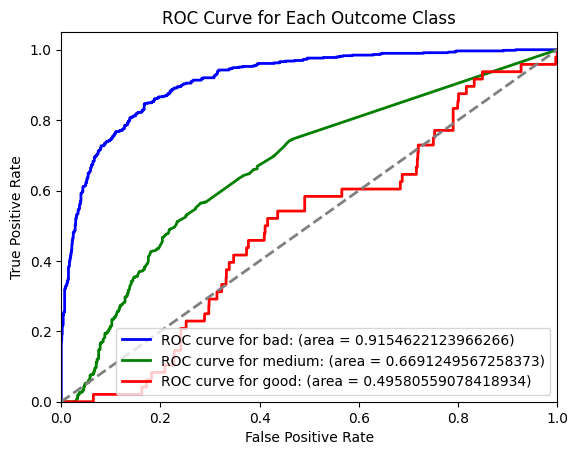

In [ ]:
multiclass_roc(grid_search, X_test)

## Feature Importance for Random Forest

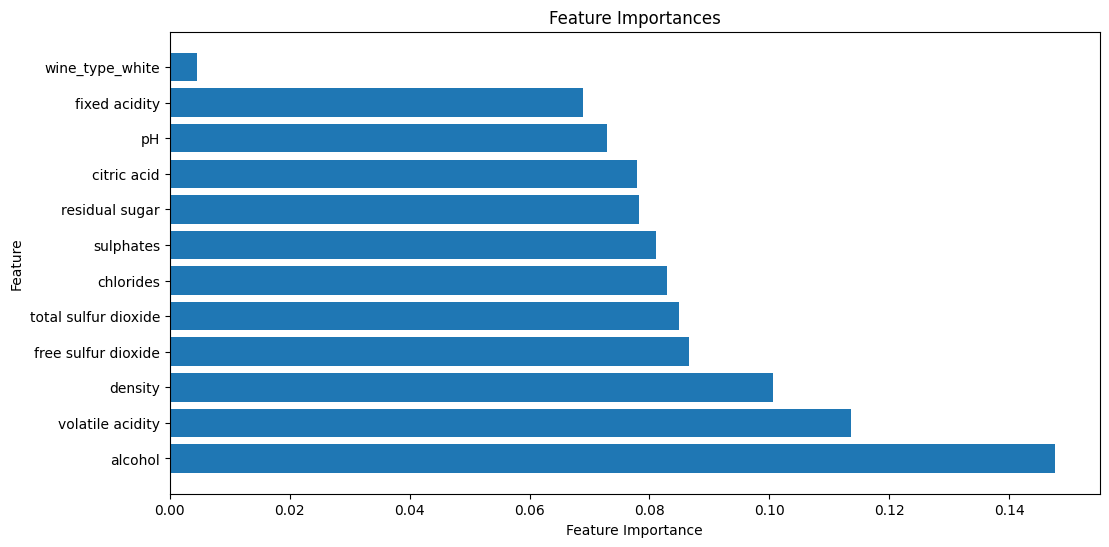

In [ ]:
print_feature_imp(processed_colnames, grid_search)

In [ ]:
acc_sco = accuracy_score(y_test, grid_search.predict(X_test))
tuned_models['Random_Forest'] = {'accuracy': acc_sco}

## Random Forest model saving / loading

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_RF_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

Are you sure you want to run this cell? It will overwrite current best model. Y/N: Y


In [ ]:
# load the best model from disk using pickle
with open('best_RF_model.pkl', 'rb') as f:
    model = pickle.load(f)

# print('Best parameters after the grid search: ', model.best_params_)


## XGBoost test

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('model', xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=2023))
])

# Define the parameter grid
param_grid = {
    'model__n_estimators': [150, 250,500],
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__max_depth': [None, 3, 5],
    'model__min_child_weight': [1, 3],
    'model__gamma': [0, 0.1],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=4, verbose=2, n_jobs=4)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train_encoded)

# Decode the predicted labels
y_test_encoded = label_encoder.transform(y_test)
y_pred_encoded = grid_search.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the best model on the test set
score = accuracy_score(y_test, y_pred)

# Print the accuracy and best parameters
print('Accuracy on the test set:', score)
print('Best parameters after the grid search:', grid_search.best_params_)



Fitting 4 folds for each of 108 candidates, totalling 432 fits
Accuracy on the test set: 0.8123076923076923
Best parameters after the grid search: {'model__colsample_bytree': 0.8, 'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__min_child_weight': 3, 'model__n_estimators': 250, 'model__subsample': 0.8}


## XGBoost results

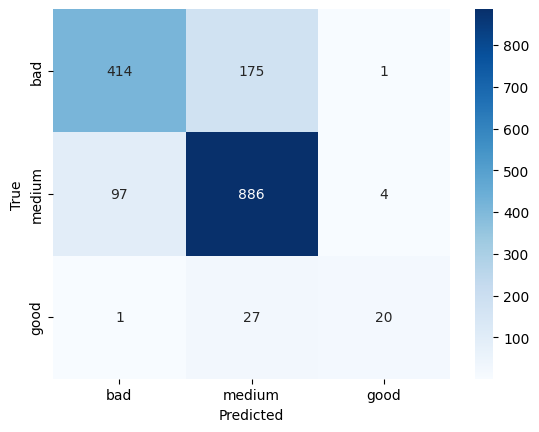

              precision    recall  f1-score   support

         bad     0.8086    0.7017    0.7514       590
      medium     0.8143    0.8977    0.8540       987
        good     0.8000    0.4167    0.5479        48

    accuracy                         0.8123      1625
   macro avg     0.8076    0.6720    0.7178      1625
weighted avg     0.8118    0.8123    0.8077      1625



In [ ]:
# construction confusion matrix
cm = conf_mat(grid_search, y_pred, y_test)

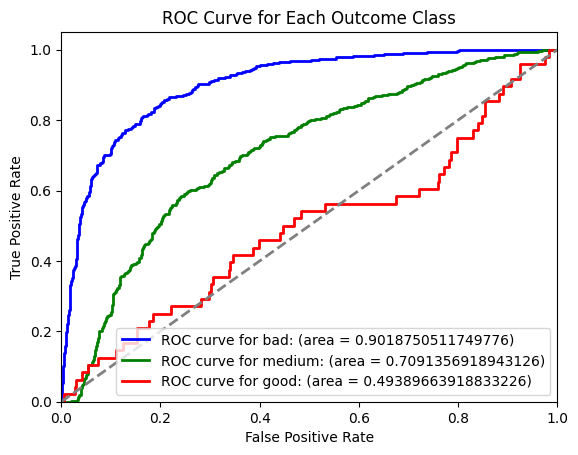

In [ ]:
Y_pred_prob = grid_search.predict_proba(X_test)
roc_auc_weighted = roc_auc_score(y_test, Y_pred_prob, multi_class='ovr', average='weighted')

multiclass_roc(grid_search, X_test)

## Feature Importance for XGBoost

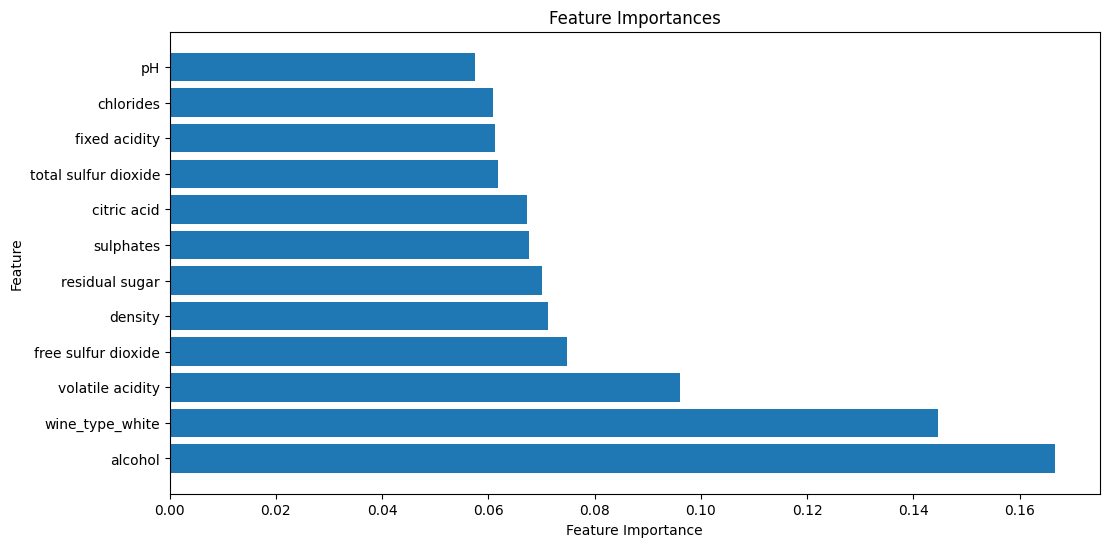

In [ ]:
print_feature_imp(processed_colnames, grid_search)

In [ ]:
acc_sco = accuracy_score(y_test, y_pred)
tuned_models['XGBoost'] = {'accuracy': acc_sco}

## Saving // Loading XGB Model

In [ ]:
# save the model to disk using pickle
if input('Are you sure you want to run this cell? It will overwrite current best model. Y/N: ') == 'Y':
    with open('best_XGB_model.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

Are you sure you want to run this cell? It will overwrite current best model. Y/N: Y


In [ ]:
# load the best model from disk using pickle
with open('best_XGB_model.pkl', 'rb') as f:
    model = pickle.load(f)

# print('Best parameters after the grid search: ', model.best_params_)


SVC Model Using pipeline

In [ ]:
# starting the timer to see how much time it takes
start_time = time.time()

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Let's define the model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('imputer', KNNImputer()),
    ('selector', SelectKBest()),
    ('model', SVC())
])

# Define the parameter grid
param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}
# create the grid search object
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=4, scoring='accuracy', verbose=2, n_jobs=4)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train_encoded)

# Decode the predicted labels
y_test_encoded = label_encoder.transform(y_test)
y_pred_encoded = grid_search.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)


# Evaluate the best model on the test set
score = accuracy_score(y_test, y_pred)

# stopping the timer and seeing the result: ------------------------
end_time = time.time()

print('Accuracy on the test set: ', score)
print('\nBest parameters after the grid search: ', grid_search.best_params_)
print("\nTime taken for model to learn: ", end_time - start_time, " seconds")


Fitting 4 folds for each of 16 candidates, totalling 64 fits
Accuracy on the test set:  0.7470769230769231

Best parameters after the grid search:  {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Time taken for model to learn:  263.0806632041931  seconds


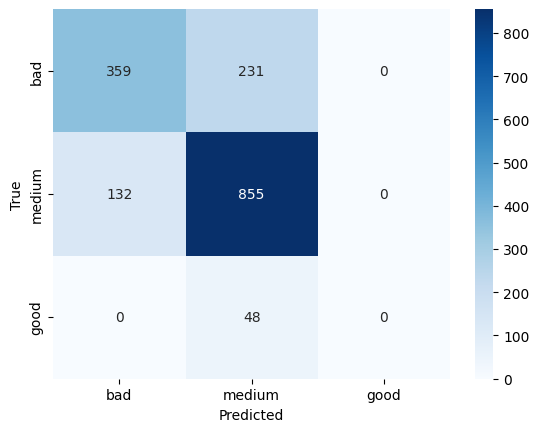

              precision    recall  f1-score   support

         bad     0.7312    0.6085    0.6642       590
      medium     0.7540    0.8663    0.8062       987
        good     0.0000    0.0000    0.0000        48

    accuracy                         0.7471      1625
   macro avg     0.4950    0.4916    0.4901      1625
weighted avg     0.7234    0.7471    0.7308      1625



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# construction confusion matrix
cm = conf_mat(grid_search, y_pred, y_test)

In [ ]:
acc_sco = accuracy_score(y_test, y_pred)
tuned_models['SVM'] = {'accuracy': acc_sco}

### Printing a comparison of models accuracies on the test set


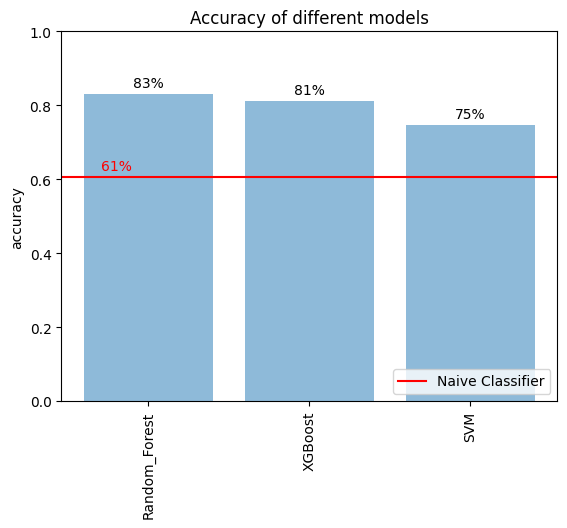

In [ ]:
plot_models_acc(tuned_models, naive_classifier)